# Better sampling *with* replacement?

In [1]:
import numpy as np, pylab as pl
from arsenal.maths import random_dist, sample, spherical

In [2]:
def mc(p, u):
    return importance_sampling(p,p,u)
    
def importance_sampling(p, q, u):
    n = len(p); k = len(u)
    Y = sample(q, u=u)
    x = np.zeros(n)
    for i in Y:
        x[i] += p[i]/q[i]
    return x / k

Next, we will consider applying the Horvitz–Thompson estimator for sampling *with* replacement from a finite population.  Below, is an implementation of the estimator.

In [3]:
def mc_ht(p, q, u):
    n = len(p); k = len(u)
    Y = sample(q, u=u)      # sample with replacement from q
    S = set(Y)              # removes duplicates [ |Y| <= k ]
    pi = (1 - (1 - q)**k)   # inclusion probabilities
    return ht(p, pi, S)
    
def ht(p, pi, S):
    x = np.zeros(n)
    for i in S: x[i] += p[i]/pi[i]  # HT estimator
    return x

What's the inclusion probability $\pi$? If we take $k$ samples with replacement from $q$, what is the probability that we sample item i at least once?
$$
\begin{align}
\pi_i 
&= \mathrm{Pr}[ i \in \{ Y_1, \ldots, Y_k \} ] \\
&= 1 - \mathrm{Pr}[ i \not\in \{ Y_1, \ldots, Y_k \} ] \\
&= 1 - Pr[ Y_1 \ne i ] \cdot \ldots \cdot Pr[ Y_k \ne i ]   \quad\text{# } Y_1 \ldots Y_k \text{ are independent} \\
&= 1 - Pr[ Y \ne i ]^k     \quad\text{# $Y$'s are identically distributed} \\
&= 1 - (1 - q_i)^k
\end{align}
$$
    
Warning: This design might not sample $k$ distinct items.  Thus, the inclusion probabilties sum to less than k, $\sum_{i=1}^n 1 - (1 - q_i)^k \le k$

## Experiment

Set up a synthetic estimation problem.

In [4]:
def anneal(p, gamma):
    q = p**gamma
    q /= q.sum()
    return q

n = 10
p = anneal(random_dist(n), 2)

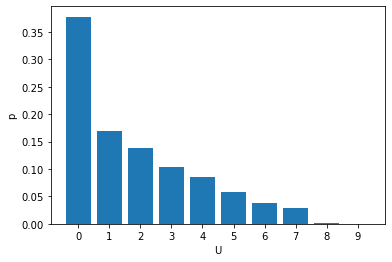

In [5]:
pl.bar(range(n), np.sort(p)[::-1]); pl.ylabel('p'); pl.xlabel('U'); pl.xticks(range(n));

In [6]:
T = 100
reps = 100
ts = range(1,1+T)

def ht_annealed(p, u): return mc_ht(p, anneal(p, 0.5), u)
def ht_uniform(p, u):  return mc_ht(p, np.ones(n)/n, u)
def ht_direct(p, u):   return mc_ht(p, p, u)

def imp(p, u):         return importance_sampling(p, imp.q, u)
imp.q = anneal(p, 0.5) #random_dist(n)

In [7]:
from collections import defaultdict
from arsenal import iterview
runs = defaultdict(list)
for _ in iterview(range(reps)):
    u = np.random.uniform(0,1,size=T)    # common random numbers
    for method in [
        mc, 
        ht_direct, 
        imp,
        #ht_annealed, 
        #ht_uniform
    ]:
        run = [method(p, u[:t]) for t in range(1,T+1)]
        runs[method].append(run)

100.0% (100/100) [====================================================] 00:00:01


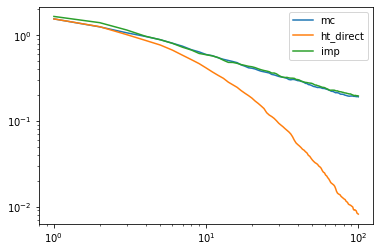

In [8]:
for method in runs:
    err = np.abs(runs[method] - p).sum(axis=2)
    pl.plot(ts, np.mean(err, axis=0), label=method.__name__)
pl.legend(loc='best'); pl.loglog();

# Variance analysis

### Horvitz–Thompson variance

The general formula for the variance of the HT estimator is [DOUBLE CHECK; this might be making extra assumptions about the design]
$$
\mathrm{Var}\left[ \mu_{\text{ht}} \right] = \sum_{i=1}^n \pi_i \left( \frac{p_i}{\pi_i} - p_i \right)^2 + (1-\pi_i) p_i^2 
= \sum_{i=1}^m  \frac{p_i^2}{\pi_i} - p_i^2
$$

XXX: revise with the derivation later in this document.  This equations works as the min-var objective regardless of indep assumptions on the sampling design.

In [9]:
def ht_variance(p, pi, k):
    return sum(
        p[i]**2/pi[i] - p[i]**2
        for i in range(n)
    )

For estimators with the general HT form, the minimum variance choice for $\pi$ is choice used in threshold sampling.  However, the scheme only controls the expected size of the sample to equal $k$.  Tweaking the scheme to sample exactly $k$ is more challenging because the samples can no longer be drawn independently, which makes the expression for the variance tricky to work.

### Importance sampling variance

$$
\mathrm{Var}\left[ \mu_{\text{imp}} \right] = \frac{1}{k} \sum_{i=1}^n q_i \left( \frac{p_i}{q_i} - p_i \right)^2 + (1-q_i) p_i^2 = \frac{1}{k} \sum_{i=1}^n \frac{p_i^2}{q_i} - p_i^2
$$

In [10]:
def var_importance_sampling(p, q, k):
    n = len(p)
    x = np.zeros(n)
    for i in range(n):        
        x[i] += p[i]**2/q[i] - p[i]**2               
    return np.sum(x / k)

#### Optimal proposal distribution ($q=p$)

I have previously ranted about how the optimal proposal distribution is not $q$.  However, under the unbiased + expected squared error conditions.  It is the optimal choice for the importance sampling type estimators.  We formalized this below.

**Proposition:** The minimum variance choice for $q$ is $p$.

**Proof:** First, we write out the Lagrangian for picking $q$ with optimal variance:
$$
\begin{cases}
\underset{{q_1, \ldots q_n}}{\mathrm{minimize}}\
   & \frac{1}{k} \sum_{i=1}^n \frac{p_i^2}{q_i} \\
\mathrm{subject\ to} 
  & \sum_{i=1}^n q_i = 1 \\
  & q_1, \ldots q_n \ge 0
\end{cases}
$$

$$
L(q_1, \ldots q_n, \lambda) 
= \frac{1}{k} \sum_{i=1}^n \frac{p_i^2}{q_i}
- \lambda \left(1 - \sum_{i=1}^n q_i \right)
$$

Now, solve for $q$ and $\lambda$ which make $L$'s parital derivatives similatenously zero.
$$
\begin{align}
0
&= \nabla_{q_j}\left[  L(q_1, \ldots q_n, \lambda) \right] \\
&= \nabla_{q_j}\left[ \frac{1}{k} \sum_{i=1}^n \frac{p_i^2}{q_i}  - \lambda \left( 1 - \sum_{i=1}^n q_i \right) \right] \\ 
&= \frac{1}{k} \sum_{i=1}^n 
    \nabla_{q_j}\left[ \frac{p_i^2}{q_i} \right]  
     + \lambda \sum_{i=1}^n \nabla_{q_j}\left[ q_i \right] \\
&= \lambda - \frac{1}{k} \frac{p_j^2}{q_j^2} \\
\lambda &= \frac{1}{k} \frac{p_j^2}{q_j^2} \\
q_j^2 &= \frac{p_j^2 }{ k \lambda } \\
\sqrt{q_j^2} &= \sqrt{\frac{p_j^2 }{ k \lambda }} \\
q_j &= \frac{p_j}{ \sqrt{ k \lambda }} \\
\end{align}
$$

and, the constraint that $\nabla_\lambda L = 0$ just replicates the constraint corresponding to $\lambda$.
$$
\begin{align}
\left(1 - \sum_{i=1}^n q_i \right) &= 0 \\
1 &= \sum_{i=1}^n q_i
\end{align}
$$

Clearly, the only valid solution to all these equations is $q = p$.

## What's going on?

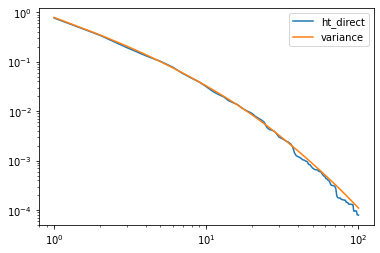

In [11]:
def variance(p, q, k):
    assert len(p) == len(q) == n, [len(p), len(q), n]
    assert np.allclose(np.sum(q), 1.0)
    incl = 1 - (1 - q)**k    
    return ht_variance(p, incl, k)

method = ht_direct
err = (np.abs(runs[method] - p[None,None,:])**2).sum(axis=2)
pl.plot(ts, np.mean(err, axis=0), label=method.__name__)
pl.plot(ts, [variance(p, p, t) for t in ts], label='variance')
pl.legend(loc='best'); pl.loglog();

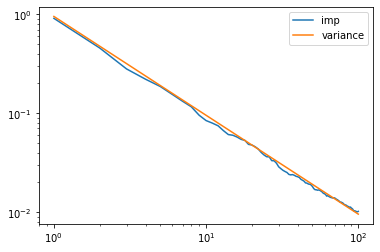

In [12]:
method = imp
err = (np.abs(runs[method] - p[None,None,:])**2).sum(axis=2)
pl.plot(ts, np.mean(err, axis=0), label=method.__name__)
pl.plot(ts, [var_importance_sampling(p, imp.q, t) for t in ts], label='variance')
pl.legend(loc='best'); pl.loglog();

In [13]:
def d_variance(p, q, k):
    incl = (1-(1-q)**k)
    return p**2 * -incl**-2 * (1-q)**(k-1) * k

from arsenal.maths import fdcheck, random_dist
k = 20
q = random_dist(n)
fdcheck(lambda: variance(p, q, k), q, d_variance(p, q, k), throw=False);


Comparison: n=10
  norms: [104.918, 104.914]
  zero F1: 1
  pearson: 1
  spearman: 1
  ℓ∞: 0.00305171
  ℓ₂: 0.00305171
  same-sign: 100.0% (10/10)
  regression: [1.000 0.000]
  got is larger: 100.0% (10/10)



100.0% (10/10) [======================================================] 00:00:00


In [14]:
from scipy.optimize import minimize
from arsenal.maths import softmax, d_softmax, spherical

def d_variance_softmax(p, w, k):
    q = softmax(w)
    dq = d_variance(p, q, k)
    return d_softmax(q, w, dq)

w = spherical(n)
k = 5
fdcheck(lambda: variance(p, softmax(w), k), w, d_variance_softmax(p, w, k), throw=False);


Comparison: n=10
  norms: [0.17376, 0.17376]
  zero F1: 1
  pearson: 1
  spearman: 1
  ℓ∞: 8.98651e-12
  ℓ₂: 1.52365e-11
  same-sign: 100.0% (10/10)
  regression: [1.000 0.000]



100.0% (10/10) [======================================================] 00:00:00


In [15]:
from arsenal import iterview
solutions = []
xxx = np.log(p)
for t in iterview(ts):
    sol = minimize(lambda w: variance(p, softmax(w), k=t), xxx, 
                   jac=lambda w: d_variance_softmax(p, w, k=t))
    solutions.append(softmax(sol.x))
    xxx = sol.x
    
# I believe, but have not proved, q*=p when k=1 
assert np.allclose(p, solutions[0])

100.0% (100/100) [====================================================] 00:00:00


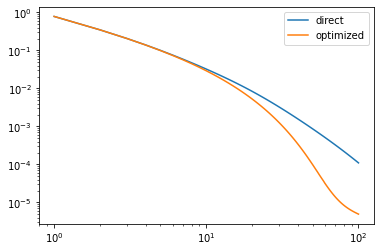

In [16]:
pl.plot(ts, [variance(p, p, t) for t in ts], label='direct')
pl.plot(ts, [variance(p, q, t) for q, t in zip(solutions, ts)], label='optimized')
pl.loglog(); pl.legend(loc='best');

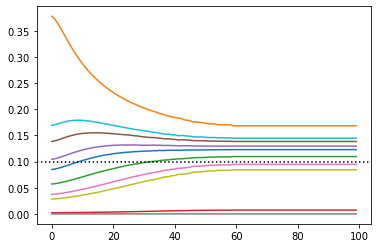

In [17]:
pl.plot(np.array(solutions));
pl.axhline(1/n, linestyle=':',c='k');

In [18]:
from arsenal import iterview
sol = minimize(lambda w: var_importance_sampling(p, softmax(w), k=t), np.zeros(n))
imp_solution = softmax(sol.x)

In [19]:
compare(imp_solution, p);


Comparison: n=10
  norms: [0.46256, 0.462725]
  zero F1: 1
  pearson: 1
  spearman: 1
  ℓ∞: 0.000172593
  ℓ₂: 0.000324929
  same-sign: 100.0% (10/10)
  regression: [0.999 0.000]

